# Data Cleaning - Train and Test Set

In this notebook, we perform data cleaning on the train and test set. We also perform preliminary analysis on the data and perform some feature engineering based on our review. 

Contents:
- [Imports](#Import-libraries-and-data)
- [Data Cleaning](#Data-cleaning)
- [Species that are WNV carriers](#Species-that-are-WNV-carriers)
- [Impute number of mosquitoes iteratively on test set](#Impute-number-of-mosquitoes-iteratively-on-test-set)
- [Save cleaned train and test set](#Save-clean-train-and-test-set)

### Import libraries and data

In [56]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('whitegrid')

from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [57]:
# import data
train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")

In [58]:
# check data
display(train.head())
print("Shape of train set: ", train.shape)
display(test.head())
print("Shape of test set: ", test.shape)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


Shape of train set:  (10506, 12)


,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


Shape of test set:  (116293, 11)


<u>Observations on these datasets :</u>

**Train Dataset**

`Address` and `AddressNumberAndStreet` appear to be similar. The difference is that the latter is obtained via GeoCoder and how similar it is to the former depends on the `AddressAccuracy` field. It appears to be repetitive but if say the address was erroneously encoded, it might affect the accuracy of our prediction so we will perform further analysis on this below first. 


`Trap` that starts with T,means that it is a satellite trap, which was put up to enhance surveillance efforts (Kaggle, 2015).

From the data description on Kaggle, the train set contains data of year 2007, 2009, 2011 and 2013. 

**Test Dataset**

We see the exact same fields on the test set except that it doesn't have `NumMosquitos` and `WnvPresent`.

Also, test set contains data from 2008, 2010, 2012 and 2014. 

### Data cleaning
Here we reformat the datasets, perform a preliminary review of the data in train and test sets. Review includes dealing with null values.

In [59]:
# adjust formatting for datasets.
def reformat(df):
    ''' function that changes the formatting of dataframe by making column names all to lowercase and make the date to datetime format'''
    df.rename(columns = str.lower, inplace = True) #change header to lowercase for easy handling
    df['date'] = pd.to_datetime(df['date']) #change date to date time format
    return df

In [60]:
#reformat all datasets
train = reformat(train)
test = reformat(test)

In [61]:
#check that changes are put through
display(train.head())
print("Datatypes for columns in train set: ", train.dtypes)
display(test.head())
print("Datatypes for columns in test set: ", test.dtypes)

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


Datatypes for columns in train set:  date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
nummosquitos                       int64
wnvpresent                         int64
dtype: object


,id,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


Datatypes for columns in test set:  id                                 int64
date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
dtype: object


Perform preliminary review using pandas profiling report. 

In [62]:
#generate html summary of report about data (train set)
report = ProfileReport(train)
report.to_file(output_file = 'train.html')
print("Report is ready for analysis!")


Report is ready for analysis!


Insights from the report on train dataset :

1. There is no need to deal with missing data since there are no missing values.


2. There are 813 duplicate rows which as stated, in the kaggle description, is because the organization of the test results are such that when number of mosquitoes exceed 50, they are split into another record (ie. there will be duplicate record) the number of times it exceeds multiple of 50. I will count the number of duplicated rows for an entry and use that to estimate the actual number of mosquitoes.


3. There are 7 species of mosquitoes, and some are more common than others. We have to perform further analysis on this later on as this may suggest that WNV are more likely to propagate through certain mosquito species. 


4. For `addressaccuracy`, 82% of the data are within the range 8-9, which is pretty comfortable. The 18% of data had 3 or 5 accuracy level. While the percentage is low, I will still investigate the addresses of these 18% and subsequently evaluate if it is better to rely on the `address` or `addressnumberandstreet`. Once decided, I will drop the `addressaccuracy` field. 


5. For `nummosquitos`, which is the number of mosquitoes caught in the trap, most frequently occuring values are a count of 1 (22% of data), count of 2 (12.4% of data) and count of 50 (or >50 as described earlier) (9.7% of data). This may suggest that there are areas with mosquito clusters (ie. areas where at least 50 mosquitoes are caught in the trap) and there are areas where mosquitoes are sparse (ie. having just one mosquito caught in the trap). The West Nile Virus (WNV) are spread through mosquitoes so the more mosquitoes the higher the likelihood of virus propagating in the area. While the test set did not have this field, this field has information that could increase accuracy of predicting of whether WNV is present in the area or not. We will therefore create data for (expected) number of mosquitoes in the locations stated in the test set. 


6. `wnvpresent` is our target variable and the report shows an imbalanced class here with about 95% of data showing 0 (WNV not present) and only 5% showing 1 (WNV present). As this is a binary classification problem, this imbalance may cause a skew in predictions. So we will use a technique to balance the classes in the train set later during preprocessing, prior to modelling. 

View profile report for test set, and determine if any further cleaning is needed. 

In [63]:
#generate html summary of report about data (test set)
report  = ProfileReport(test)
report.to_file(output_file = 'test.html')
print("Report is ready for analysis!")


Report is ready for analysis!


Insights from report on test set:

1. No missing data and no duplicate rows.


2. Test data includes an `id` field for kaggle submission.


3. For `addressaccuracy`, 87% of the data had at least an 8 accuracy while the rest of the 13% had either a 3 or a 5. The proportion is similar to the train set. Any cleaning done on the train set for this field, will be mirrored for the test set. 

We execute the changes mentioned above.

**Address Accuracy**

In [64]:
# view data with 5 and 3 accuracy scores to determine if low accuracy score results in a huge discrepancy in address
train_addacc_5_3 = train[(train.addressaccuracy == 5) | (train.addressaccuracy == 3)]
train_addacc_5_3.head(3)

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
19,2007-05-29,"North Streeter Drive, Chicago, IL 60611, USA",CULEX PIPIENS/RESTUANS,53,N STREETER DR,T129,"5300 N STREETER DR, Chicago, IL",41.891126,-87.61156,5,1,0
20,2007-05-29,"North Streeter Drive, Chicago, IL 60611, USA",CULEX RESTUANS,53,N STREETER DR,T129,"5300 N STREETER DR, Chicago, IL",41.891126,-87.61156,5,2,0
58,2007-06-05,"South Vincennes Avenue, Chicago, IL, USA",CULEX RESTUANS,10,S VINCENNES,T089,"1000 S VINCENNES, Chicago, IL",41.723195,-87.64997,5,1,0


From review of the data above with addresses of accuracy 5 and 3, there appears to be not much difference, and addresses and coordinates do not display a large error margin. Therefore, I will retain these data. 

Going forward, the `address`, `block`, `street`, `addressnumberandstreet`, and `addressaccuracy` are not as relevant since the latitudes and longitudes have shown to be pretty accurate.

In [65]:
# drop abovementioned columns
train.drop(columns = ['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'], inplace = True)
test.drop(columns = ['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'], inplace = True)

In [66]:
# check that changes are put through
display(train.head())
print("Shape of train set: ", train.shape)
display(test.head())
print("Shape of test set: ", test.shape)

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0


Shape of train set:  (10506, 7)


,id,date,species,trap,latitude,longitude
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991


Shape of test set:  (116293, 6)


**Duplicate entries for number of mosquitoes > 50**

Find duplicate entries where the number of mosquitoes for the location exceeds 50, and add up these numbers to result in the actual number of mosquitoes for the trap site.

In [67]:
# duplicated rows have the same values for the columns below
cols = ['date','species','latitude','longitude']

for index, row in train.iterrows():
    
    # skip 1st row
    if index > 0:
        
        # reset counter for each row
        duplicate_count = 0        
        
        for col in cols:
            
            # compare cells in current and previous rows
            # increment counter if both cells have the same value 
            if train.at[index,col] == train.at[index-1,col]:
                duplicate_count += 1               
                
        # counter equal to number of selected column
        # current row['nummosquitos','wnvpresent'] = sum of current and previous rows
        if duplicate_count == len(cols):
            train.at[index,'nummosquitos'] = train.at[index,'nummosquitos'] + train.at[index-1,'nummosquitos']
            train.at[index,'wnvpresent'] = train.at[index,'wnvpresent'] + train.at[index-1,'wnvpresent']

# remove duplicated rows (keep only last row)
train.drop_duplicates(subset=cols, keep='last',inplace=True)

Feature engineer the WNV presence frequency for each trap location, and apply the same for the test set. 

In [68]:
#compute frequency of the wnvpresence for each poitn
train['wnvpresencefreq'] = (train['wnvpresent'] / (train['wnvpresent'].sum()))

In [69]:
# create df for trap location and wnvpresence frequency
trap_freq = pd.DataFrame(train.groupby('trap').mean()['wnvpresencefreq']).reset_index()
#check
trap_freq.head(3)

,trap,wnvpresencefreq
0,T001,0.000000
1,T002,0.000222
2,T003,0.000225


In [70]:
# merge
test = pd.merge(test, trap_freq, on = 'trap', how = 'left')
test.fillna(0, inplace = True)
#check
test.head()

,id,date,species,trap,latitude,longitude,wnvpresencefreq
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,0.000222
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,0.000222
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,0.000222
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,0.000222
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,0.000222


In [71]:
test.isnull().sum()

id                 0
date               0
species            0
trap               0
latitude           0
longitude          0
wnvpresencefreq    0
dtype: int64

In [72]:
# change wnvpresent to binary classification
train.wnvpresent = [1 if x > 0 else 0 for x in train.wnvpresent]

### Species that are WNV carriers
Now that the train data is cleaned, let's analyse the species and whether some species are more likely to be a WNV carrier.

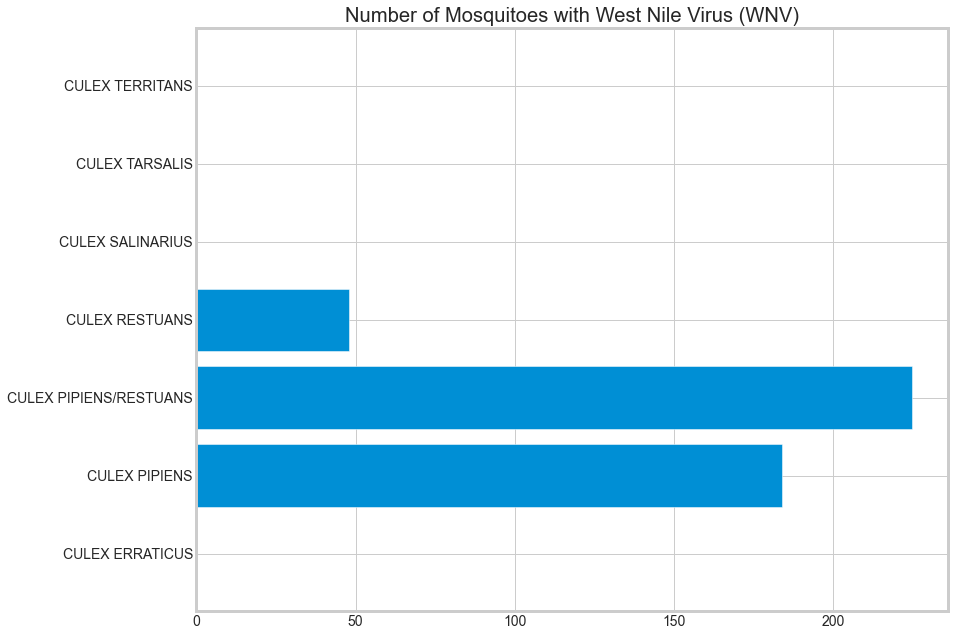

In [73]:
# analyse species with wnv presence.
species_wnv = train[['species', 'nummosquitos', 'wnvpresent']].groupby('species').sum()
species_wnv.reset_index(inplace = True)
# plot
plt.figure(figsize = (12,10))
plt.barh(species_wnv['species'], species_wnv['wnvpresent'])
plt.title('Number of Mosquitoes with West Nile Virus (WNV)')
plt.show();

It appears that only certain species are carriers of the WNV - culex pipiens, culex pipiens/restuans, culex restuans.

### Impute number of mosquitoes iteratively on test set
The number of mosquitoes in the trap is a relatively important field, as the more the number of mosquitoes, the higher the likelihood of WNV presence. Since the test set provided did not have this, we will iteratively impute the number of mosquitoes for the test set. 

In [74]:
def add_nummosq_to_test(train, test):
    '''function will add  number of mosquitoes to test set using iterative imputation based on values on train set'''
    test['nummosquitos'] = np.nan
    # create dataframe for coordinates and number of mosquitoes
    train_nummosq = train[['latitude','longitude','nummosquitos']]
    print("Shape for train set:" + str(train_nummosq.shape))
    test_nummosq = test[['latitude','longitude','nummosquitos']]
    print("Shape for test set:" + str(test_nummosq.shape))
    # merge dataframes in prep for iterative imputation
    merged_nummosq = pd.concat([train_nummosq,test_nummosq])
    
    #instantiate imputer
    imp = IterativeImputer()
    # fit and transform
    merged_nummosq = pd.DataFrame(imp.fit_transform(merged_nummosq))
    # rename columns and round ooff
    merged_nummosq.rename(columns = {0: 'latitude', 1 : 'longitude', 2: 'nummosquitos'}, inplace = True)
    merged_nummosq['nummosquitos'] = merged_nummosq['nummosquitos'].round(decimals = 0)
    # get the updated test set 
    test_updated_nummosq = merged_nummosq.loc[train_nummosq.shape[0]:,:]
    print("Shape for updated test set: " + str(test_updated_nummosq.shape))
    # reset index
    test_updated_nummosq.reset_index(inplace = True)
    # update test set 
    test['nummosquitos'] = test_updated_nummosq['nummosquitos']
    return test

In [75]:
add_nummosq_to_test(train, test)

Shape for train set:(8475, 3)
Shape for test set:(116293, 3)
Shape for updated test set: (116293, 3)


,id,date,species,trap,latitude,longitude,wnvpresencefreq,nummosquitos
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0.000222,14.0
1,2,2008-06-11,CULEX RESTUANS,T002,41.954690,-87.800991,0.000222,14.0
2,3,2008-06-11,CULEX PIPIENS,T002,41.954690,-87.800991,0.000222,14.0
3,4,2008-06-11,CULEX SALINARIUS,T002,41.954690,-87.800991,0.000222,14.0
4,5,2008-06-11,CULEX TERRITANS,T002,41.954690,-87.800991,0.000222,14.0
...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,T054C,41.925652,-87.633590,0.000202,7.0
116289,116290,2014-10-02,CULEX TERRITANS,T054C,41.925652,-87.633590,0.000202,7.0
116290,116291,2014-10-02,CULEX TARSALIS,T054C,41.925652,-87.633590,0.000202,7.0
116291,116292,2014-10-02,UNSPECIFIED CULEX,T054C,41.925652,-87.633590,0.000202,7.0


### Save clean train and test set

In [76]:
train.to_csv("../data/clean/train_clean.csv", index = False)
test.to_csv("../data/clean/test_clean.csv", index = False)

### References

West Nile Virus Prediction - Data Description (Kaggle, 2015)
https://www.kaggle.com/c/predict-west-nile-virus/data